In [140]:
import pandas as pd
import csv
import string
jeopardy_all =pd.read_csv('JEOPARDY_CSV.csv')
jeopardy = jeopardy_all.sample(frac=0.1, random_state =2)

In [141]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [142]:
jeopardy = jeopardy.rename(columns = lambda x:x.replace(' ',''))
jeopardy.columns

Index(['ShowNumber', 'AirDate', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [143]:
def normalize_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
    return text    
    

In [144]:
jeopardy['clean_question']=jeopardy['Question'].apply(normalize_text)
jeopardy["clean_answer"] = jeopardy["Answer"].apply(normalize_text)

In [145]:
def normalize_value(value):
    value ="".join(char for char in value if char not in string.punctuation)
    try:
        normalized_value = int(value)
    except ValueError:
        normalized_value = 0
    return normalized_value

In [146]:
jeopardy["clean_value"] = jeopardy["Value"].apply(normalize_value)

In [147]:
jeopardy

,ShowNumber,AirDate,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value
41127,5925,2010-05-21,Jeopardy!,CAUSED BY...,$1000,"Hypovolemic, a type of shock",loss of blood,hypovolemic a type of shock,loss of blood,1000
71199,5920,2010-05-14,Jeopardy!,BOXING TERMS SANS BOXING,$600,"Hey, ya palooka, I got you a lawyer... yeah, h...",a mouthpiece,hey ya palooka i got you a lawyer yeah hes als...,a mouthpiece,600
7555,6072,2011-01-25,Jeopardy!,GAMES,$1000,"In terms of the use of fingers, it's the game ...","Rock, Paper, Scissors",in terms of the use of fingers its the game in...,rock paper scissors,1000
113522,5519,2008-09-11,Jeopardy!,LOVE AFFAIR,$400,This 1878 title gal has a child with her hubby...,Anna Karenina,this 1878 title gal has a child with her hubby...,anna karenina,400
89219,1486,1991-02-04,Double Jeopardy!,HOLIDAYS & OBSERVANCES,$400,"In Canada, the Monday before May 25th is a hol...",Queen Victoria,in canada the monday before may 25th is a holi...,queen victoria,400
...,...,...,...,...,...,...,...,...,...,...
70448,4,1984-09-13,Double Jeopardy!,THE CIVIL WAR,$200,Lincoln's four brothers-in-law all served in t...,the Confederate army,lincolns four brothersinlaw all served in this...,the confederate army,200
34822,5744,2009-07-23,Double Jeopardy!,ABBREV.,$1200,"It's what the ""N"" stands for in NICU, an inten...",neonatal,its what the n stands for in nicu an intensive...,neonatal,1200
214009,6011,2010-11-01,Jeopardy!,SINGLE-NAMED SINGERS' LAST NAMES,$400,Late Tejano singer: Quintanilla,Selena,late tejano singer quintanilla,selena,400
145192,2862,1997-01-28,Jeopardy!,SPORTS STARS,$400,In 1995 this Cleveland slugger led the America...,Albert Belle,in 1995 this cleveland slugger led the america...,albert belle,400


In [148]:
jeopardy["AirDate"] = pd.to_datetime(jeopardy["AirDate"])
jeopardy.dtypes

ShowNumber                 int64
AirDate           datetime64[ns]
Round                     object
Category                  object
Value                     object
Question                  object
Answer                    object
clean_question            object
clean_answer              object
clean_value                int64
dtype: object

In [149]:
def count_matches(row):
    split_answer = str(row['clean_answer']).split()
    split_question = str(row['clean_question']).split()
    if 'the' in split_answer:
        split_answer.remove("the")
    match_count = 0
    for item in split_question:
        if item in split_answer:
            match_count +=1
    if len(split_answer) > 0:       
        return match_count / len(split_answer)
    else:
        return 0

jeopardy["answer_in_question"] = jeopardy.apply(count_matches, axis=1)        

In [150]:
jeopardy["answer_in_question"].mean()

0.06862692297279469

### Recycled Questions
On average, the answer only makes up for about 7% of the question. This isn't a huge number, and it means that we probably can't just hope that hearing a question will enable us to determine the answer. We'll probably have to study.

In [151]:
jeopardy['clean_question'].head()

41127                           hypovolemic a type of shock
71199     hey ya palooka i got you a lawyer yeah hes als...
7555      in terms of the use of fingers its the game in...
113522    this 1878 title gal has a child with her hubby...
89219     in canada the monday before may 25th is a holi...
Name: clean_question, dtype: object

In [152]:
question_overlap = []
terms_used = set()

jeopardy = jeopardy.sort_values("AirDate")

for i, row in jeopardy.iterrows():
        split_question = row["clean_question"].split(" ")
        split_question = [q for q in split_question if len(q) > 5]
        match_count = 0
        for word in split_question:
            if word in terms_used:
                match_count += 1
        for word in split_question:
            terms_used.add(word)
        if len(split_question) > 0:
            match_count /= len(split_question)
        question_overlap.append(match_count)
jeopardy["question_overlap"] = question_overlap

jeopardy["question_overlap"].mean()   


0.6963876610083568

### Low Value vs. High Value Questions
There is about a 70% overlap between terms in new questions and terms in old questions. This only looks at a small set of questions, and it doesn't look at phrases — it looks at single terms. This makes it relatively insignificant, but it does mean that it's worth looking more into the recycling of questions.

In [153]:
def determine_value(row):
    value = 0
    if row["clean_value"] > 800:
        value = 1
    return value

jeopardy["high_value"] = jeopardy.apply(determine_value, axis=1)

In [154]:
def count_usage(term):
    low_count = 0
    high_count = 0
    for i, row in jeopardy.iterrows():
        if term in row["clean_question"].split(" "):
            if row["high_value"] == 1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count    

In [155]:
from random import choice

terms_used_list = list(terms_used)
comparison_terms = [choice(terms_used_list) for _ in range(10)]

observed_expected = []

for term in comparison_terms:
    observed_expected.append(count_usage(term))

observed_expected

[(0, 1),
 (0, 1),
 (0, 1),
 (0, 2),
 (0, 1),
 (0, 4),
 (1, 3),
 (2, 0),
 (1, 0),
 (0, 1)]

In [156]:
from scipy.stats import chisquare
import numpy as np

high_value_count = jeopardy[jeopardy["high_value"] == 1].shape[0]
low_value_count = jeopardy[jeopardy["high_value"] == 0].shape[0]

chi_squared = []
for obs in observed_expected:
    total = sum(obs)
    total_prop = total / jeopardy.shape[0]
    high_value_exp = total_prop * high_value_count
    low_value_exp = total_prop * low_value_count
    
    observed = np.array([obs[0], obs[1]])
    expected = np.array([high_value_exp, low_value_exp])
    chi_squared.append(chisquare(observed, expected))

chi_squared

[Power_divergenceResult(statistic=0.4067181116659101, pvalue=0.5236399800157328),
 Power_divergenceResult(statistic=0.4067181116659101, pvalue=0.5236399800157328),
 Power_divergenceResult(statistic=0.4067181116659101, pvalue=0.5236399800157328),
 Power_divergenceResult(statistic=0.8134362233318202, pvalue=0.3671062764816485),
 Power_divergenceResult(statistic=0.4067181116659101, pvalue=0.5236399800157328),
 Power_divergenceResult(statistic=1.6268724466636404, pvalue=0.2021361794136462),
 Power_divergenceResult(statistic=0.029792090534012047, pvalue=0.8629628220464778),
 Power_divergenceResult(statistic=4.917410714285715, pvalue=0.026587335293713127),
 Power_divergenceResult(statistic=2.4587053571428577, pvalue=0.11687507804961356),
 Power_divergenceResult(statistic=0.4067181116659101, pvalue=0.5236399800157328)]

### Chi-Squared Results
None of the terms had a significant difference in usage between high value and low value rows. Additionally, the frequencies were all lower than 5, so the chi-squared test isn't as valid. It would be better to run this test with only terms that have higher frequencies.

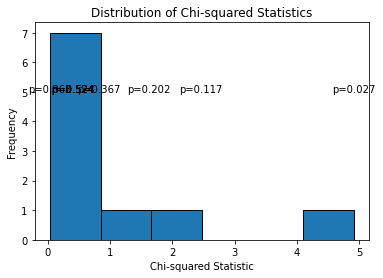

In [159]:
import matplotlib.pyplot as plt

chi_squared_values = [result.statistic for result in chi_squared]
p_values = [result.pvalue for result in chi_squared]
plt.hist(chi_squared_values, bins='auto', edgecolor='black')
plt.xlabel('Chi-squared Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Chi-squared Statistics')
for i in range(len(chi_squared_values)):
    plt.text(chi_squared_values[i], 5, f'p={p_values[i]:.3f}', ha='center')

plt.show()